# Initial WSP Data Exploration

Looking at World Stock Price dataset.

In [34]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

Some notes:

Use seasonal average model for weekends minus daylight savings weekend to create model
See how well the average predicts daylight savings weekends (null hypothesis is that there is no difference in regular weekends and daylight savings weekends)

Try seasonal average model plus linear model to account for monthly changes plus changes over the years

Use Time Series analysis

Use sklearn with rest of dataset as features and open/close as predictor

Look into using logistic regression for binary type data

In [35]:
#price2 = pd.read_csv('WSJ_HistoricalPrices(Jan 1, 1981 - Oct 10, 2024).csv')
#price1 = pd.read_csv('WSJ_HistoricalPrices(Feb 5, 1971 - Dec 31, 1980).csv')
dates = pd.read_csv('DaylightSavingsTimeChangeDates_1971-2024.csv')
wsp_data = pd.read_csv('World-Stock-Prices-Dataset.csv')

In [36]:
dst_dates_spring = pd.to_datetime(dates.Date+" "+dates.Year.astype(str))
dst_dates_winter = pd.to_datetime(dates['Date.1']+" "+dates.Year.astype(str))
dst_mon_spring = dst_dates_spring+pd.DateOffset(1)
dst_fri_spring = dst_dates_spring+pd.DateOffset(-2)
dst_mon_winter = dst_dates_winter+pd.DateOffset(1)
dst_fri_winter = dst_dates_winter+pd.DateOffset(-2)

In [37]:
#Set datetime as index
wsp_data['Date'] = pd.to_datetime(wsp_data.Date, utc=True).apply(lambda x: x.date())
wsp_data['IS_DST'] = wsp_data.Date.isin(pd.concat([dst_dates_spring, dst_dates_winter]))
wsp_data.set_index('Date', inplace=True)
wsp_data.index = wsp_data.index.astype('datetime64[ns]')

In [38]:
wsp_data.index

DatetimeIndex(['2024-10-11', '2024-10-11', '2024-10-11', '2024-10-11',
               '2024-10-11', '2024-10-11', '2024-10-11', '2024-10-11',
               '2024-10-11', '2024-10-11',
               ...
               '2000-01-03', '2000-01-03', '2000-01-03', '2000-01-03',
               '2000-01-03', '2000-01-03', '2000-01-03', '2000-01-03',
               '2000-01-03', '2000-01-03'],
              dtype='datetime64[ns]', name='Date', length=297121, freq=None)

In [39]:
wsp_data['IS_MON'] = wsp_data.index.day_of_week==0
wsp_data['IS_FRI'] = wsp_data.index.day_of_week==4
#wsp_data['IS_MON'] = pd.get_dummies(wsp_data[['IS_MON']]*1.0)
#wsp_data['IS_FRI'] = pd.get_dummies(wsp_data[['IS_FRI']]*1.0)


In [40]:
wsp_data.loc[wsp_data.Ticker=='NKE'].head(10)

,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains,IS_DST,IS_MON,IS_FRI
Date,,,,,,,,,,,,,,,
2024-10-11,82.040001,82.269997,81.184898,82.150002,8579409.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,True
2024-10-11,82.040001,82.269997,81.180000,82.150002,10166600.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,True
2024-10-10,83.400002,83.449997,82.029999,82.099998,8367300.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,False
2024-10-09,81.139999,82.930000,81.070000,82.449997,11746000.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,False
2024-10-08,80.750000,81.419998,79.930000,80.769997,10565600.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,False
2024-10-07,82.139999,82.470001,80.089996,80.830002,12760800.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,True,False
2024-10-04,82.629997,83.540001,82.099998,82.250000,10322600.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,True
2024-10-04,82.629997,83.533997,82.099998,82.250000,10314145.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,True
2024-10-03,82.400002,83.779999,81.980003,82.099998,18120900.0,nike,NKE,apparel,usa,0.0,0.0,NaN,False,False,False


In [41]:
wsp_data.shape

(297121, 15)

In [52]:
#some market values to track

def daily_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_prince = df.loc[date, 'Close']
    opne_price = df.loc[date, 'Open']
    return close_price-open_price

def daily_percent_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_price = df.loc[date, 'Close']
    open_price = df.loc[date, 'Open']
    return (close_price-open_price)/open_price

def weekend_effect(df): #df is DataFrame for one ticker, with IS_FRI and IS_MON columns
    #assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index" 
    fri_close = df.loc[df.IS_FRI].Close
    mon_open = df.loc[fri_close.index+pd.DateOffset(3)].Open
    return fri_close.to_numpy() - mon_open.to_numpy(), (fri_close.to_numpy() - mon_open.to_numpy())/fri_close.to_numpy(), fri_close.index+pd.DateOffset(2) #returns (price difference, percent difference)

In [43]:
#Data preprocessing

ticker_list = wsp_data.Ticker.unique()
dataset = pd.DataFrame()

for tk in ticker_list:
    #Select a single stock from full dataset
    tk_set = wsp_data.loc[wsp_data.Ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    #wsp_data = wsp_data.loc[~(wsp_data.Ticker == tk) | (wsp_data.index.isin(tk_set.index))]
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
wsp_data = dataset

In [ ]:
#tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]

In [ ]:
#wsp_data.loc[~(wsp_data.Ticker == 'NKE')].Ticker.unique()

In [ ]:
#Alter main dataset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
#wsp_data = wsp_data[((wsp_data.IS_MON==False) & (wsp_data.IS_FRI==False)) | (wsp_data.index.isin(mondays.index)) | (wsp_data.index.isin(fridays.index))]

In [44]:
wsp_data.Industry_Tag.unique()

array(['fitness', 'automotive', 'gaming', 'technology', 'aviation',
       'food & beverage', 'food', 'footwear', 'consumer goods',
       'hospitality', 'music', 'financial services', 'apparel', 'retail',
       'manufacturing', 'social media', 'entertainment', 'e-commerce',
       'luxury goods', 'finance', 'healthcare', 'logistics',
       'cryptocurrency'], dtype=object)

In [45]:
#weekend_effect(wsp_data.loc[wsp_data.Ticker == 'PTON'])

In [46]:
wsp_data[wsp_data.Industry_Tag=='technology']

,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains,IS_DST,IS_MON,IS_FRI
Date,,,,,,,,,,,,,,,
2024-10-10,415.230011,417.350006,413.149994,415.839996,13807800.0,microsoft,MSFT,technology,usa,0.0,0.0,NaN,False,False,False
2024-10-10,160.869995,163.070007,160.399994,162.080002,14076700.0,google,GOOGL,technology,usa,0.0,0.0,NaN,False,False,False
2024-10-10,227.779999,229.500000,227.169998,229.039993,28084100.0,apple,AAPL,technology,usa,0.0,0.0,NaN,False,False,False
2024-10-10,490.540009,506.450012,489.350006,503.570007,2774000.0,adobe,ADBE,technology,usa,0.0,0.0,NaN,False,False,False
2024-10-10,32.139999,32.139999,31.750000,31.830000,406100.0,philips,PHG,technology,netherlands,0.0,0.0,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-04,0.820377,0.838376,0.766854,0.776801,512377600.0,apple,AAPL,technology,usa,0.0,0.0,NaN,False,False,False
2000-01-04,35.273749,36.380301,34.866072,34.982552,54119000.0,microsoft,MSFT,technology,usa,0.0,0.0,NaN,False,False,False
2000-01-04,15.638579,16.336730,14.878370,14.909399,7813200.0,adobe,ADBE,technology,usa,0.0,0.0,NaN,False,False,False


In [53]:
wk = []
i=0
wt = pd.DataFrame()
tech_data = wsp_data[wsp_data.Industry_Tag=='technology']
tech_ticker_list = ticker_list = tech_data.Ticker.unique()

for tk in tech_ticker_list:
    wk.append(weekend_effect(tech_data.loc[tech_data.Ticker == tk]))
    tmp = pd.DataFrame({'Date':wk[i][2],'Price_Change':wk[i][0], 'Percent_Change':wk[i][1], "Ticker":np.full(wk[i][1].shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    wt = pd.concat([wt, tmp])
    i+=1

In [54]:
wt

,Date,Price_Change,Percent_Change,Ticker
0,2024-10-06,0.059998,0.000144,MSFT
1,2024-09-29,-0.190002,-0.000444,MSFT
2,2024-09-22,0.989990,0.002274,MSFT
3,2024-09-15,-0.010010,-0.000023,MSFT
4,2024-09-08,-5.539978,-0.013791,MSFT
...,...,...,...,...
1119,2000-02-13,-0.693978,-0.015274,CSCO
1120,2000-02-06,-1.019297,-0.024252,CSCO
1121,2000-01-30,0.325295,0.009025,CSCO
1122,2000-01-23,-0.173513,-0.004339,CSCO


In [22]:
len(tech_ticker_list)

13

In [ ]:
def gaussian(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

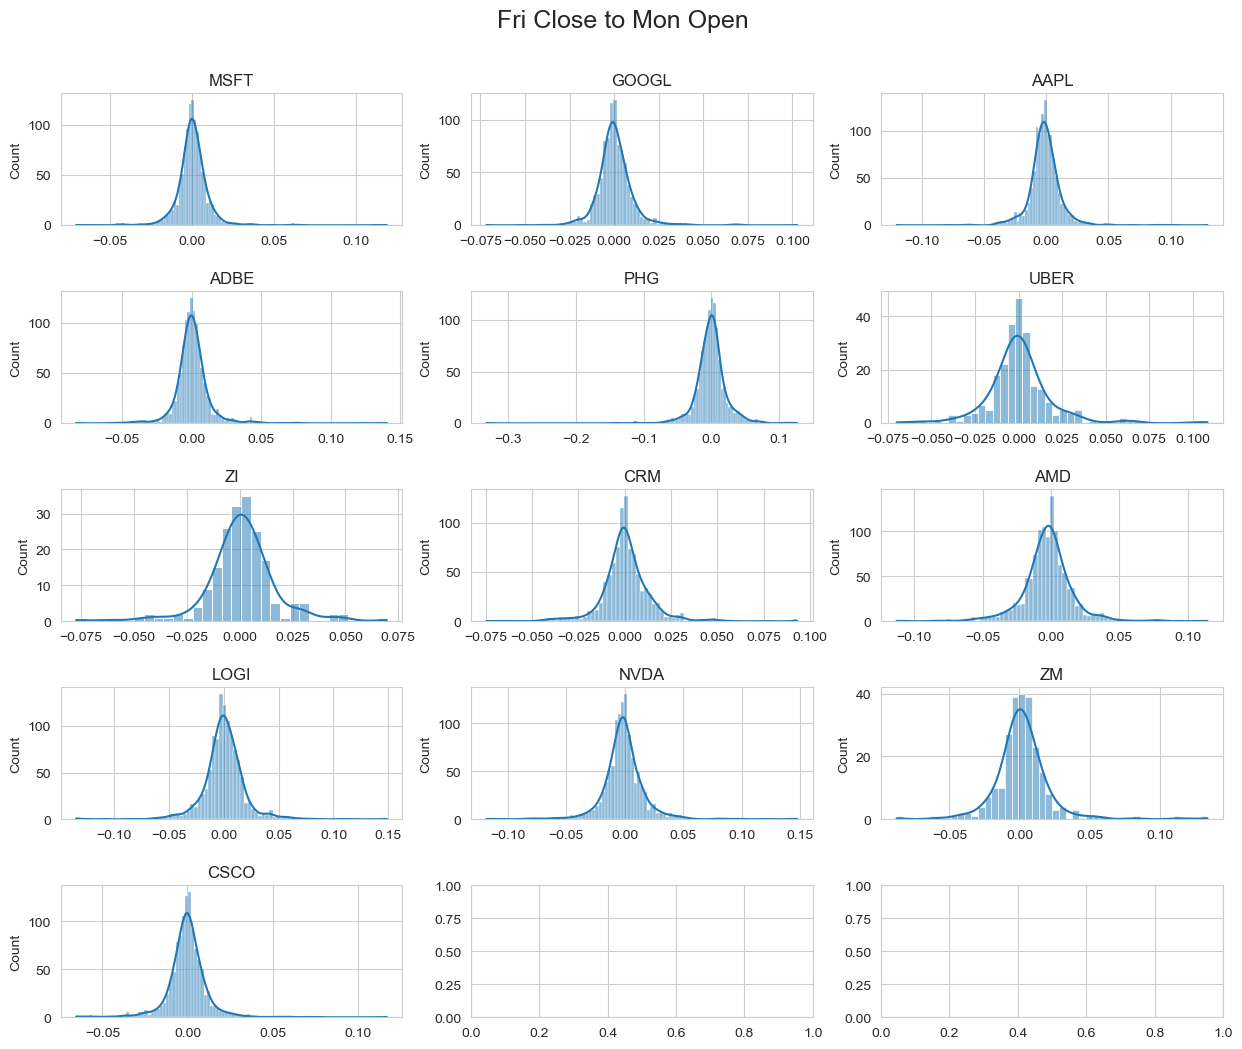

In [30]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Fri Close to Mon Open", fontsize=18, y=0.95)

# loop through tickers and axes
for tk, axes in zip(ticker_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    sns.histplot(ax=axes, data = wt.loc[wt.Ticker==tk], x="Percent_Change", kde=True)

    # chart formatting
    axes.set_title(tk.upper())
    #axes.get_legend().remove()
    axes.set_xlabel("")

plt.show()


In [ ]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Weekend Effect Over Time", fontsize=18, y=0.95)

# loop through tickers and axes
for tk, axes in zip(ticker_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    sns.scatter(ax=axes, data = wt.loc[wt.Ticker==tk], x="Percent_Change")

    # chart formatting
    axes.set_title(tk.upper())
    #axes.get_legend().remove()
    axes.set_xlabel("")

plt.show()

In [ ]:
amzn = wsp_data.loc[wsp_data.Ticker == 'AMZN'].astype({'Date': 'datetime64[ns]'}) #AMZN MSFT COST
msft = wsp_data.loc[wsp_data.Ticker == 'MSFT'].astype({'Date': 'datetime64[ns]'})
cost = wsp_data.loc[wsp_data.Ticker == 'COST'].astype({'Date': 'datetime64[ns]'})

amzn_mon_data = amzn[amzn.Date.isin(dst_mon_spring)].reset_index(drop=True)
amzn_fri_data = amzn[amzn.Date.isin(dst_fri_spring)].reset_index(drop=True)

msft_mon_data = msft[msft.Date.isin(dst_mon_spring)].reset_index(drop=True)
msft_fri_data = msft[msft.Date.isin(dst_fri_spring)].reset_index(drop=True)

cost_mon_data = cost[cost.Date.isin(dst_mon_spring)].reset_index(drop=True)
cost_fri_data = cost[cost.Date.isin(dst_fri_spring)].reset_index(drop=True)

amzn_test_data=pd.DataFrame()
amzn_test_data['DST_Date'] = amzn_mon_data.Date+pd.DateOffset(-1)
amzn_test_data['Weekend_Volume_Difference'] = amzn_fri_data.Volume - amzn_mon_data.Volume
amzn_test_data['Ticker'] = amzn_mon_data.Ticker

msft_test_data=pd.DataFrame()
msft_test_data['DST_Date'] = msft_mon_data.Date+pd.DateOffset(-1)
msft_test_data['Weekend_Volume_Difference'] = msft_fri_data.Volume - msft_mon_data.Volume
msft_test_data['Ticker'] = msft_mon_data.Ticker

cost_test_data=pd.DataFrame()
cost_test_data['DST_Date'] = cost_mon_data.Date+pd.DateOffset(-1)
cost_test_data['Weekend_Volume_Difference'] = cost_fri_data.Volume - cost_mon_data.Volume
cost_test_data['Ticker'] = cost_mon_data.Ticker

In [ ]:
dst_data = price[price.Date.isin(dst_mon_spring)].reset_index(drop=True)
#print(price[price.Date.isin(dst_mon_spring)])
test_data = pd.concat([amzn_test_data, msft_test_data, cost_test_data])

In [ ]:
sns.scatterplot(wsp_data, x='DST_Date', y='Weekend_Volume_Difference', hue='Ticker')